In [7]:
from prawn_predictor import DataProcessor
from fbprophet import Prophet
import numpy as np
import pandas as pd

In [8]:
model = Prophet(holidays_prior_scale=1, changepoint_prior_scale=0.5,
                seasonality_mode='multiplicative',
                #changepoints=['2020-03-01'],
                growth='logistic',
                yearly_seasonality=False,
                daily_seasonality=False,
                weekly_seasonality=False)
model.add_seasonality(name='halfly', period=210, fourier_order=4)
# model.add_country_holidays('US')

In [9]:
data_processor = DataProcessor()
df = data_processor.df
#df['GeoID'].unique()

['Brazil' 'United Kingdom' 'United States']


In [11]:
#m1 = df['GeoID'] == 'Aruba'
m1 = df['GeoID'] == 'United States / New York'
# m2 = df['NewCases']>0
# start_date = '2020-9-1'
# m3 = df['Date'] > start_date
df = df[ m1].copy()
df['ds'] = df['Date']
# df['y'] = df['ConfirmedCases'] + 1
df['y'] = df['NewCases']
cap = 20000
df['cap'] = cap
df['floor'] = 0
df['NewCases'].tail()
# df[df['NewCases']<10]

79341    5973.0
79342    5391.0
79343    5906.0
79344    4881.0
79345    6265.0
Name: NewCases, dtype: float64

In [5]:
NPI_COLUMNS = ['C1_School closing',
               'C2_Workplace closing',
               'C3_Cancel public events',
               'C4_Restrictions on gatherings',
               'C5_Close public transport',
               'C6_Stay at home requirements',
               'C7_Restrictions on internal movement',
               'C8_International travel controls',
               'H1_Public information campaigns',
               'H2_Testing policy',
               'H3_Contact tracing',
               'H6_Facial Coverings'
              ]
df['C_avg'] = df['C1_School closing'] + df['C2_Workplace closing']+df['C4_Restrictions on gatherings'] \
           +df['C5_Close public transport'] + df['C6_Stay at home requirements']\
           +df['C7_Restrictions on internal movement']\
           +df['C8_International travel controls']
df['H_avg'] = df['H1_Public information campaigns'] + df['H2_Testing policy'] + df['H3_Contact tracing'] \
                + df['H6_Facial Coverings']
    
USE_COLUMNS = NPI_COLUMNS

In [6]:
df.tail()

,CountryName,RegionName,GeoID,Date,ConfirmedCases,ConfirmedDeaths,Population,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,CaseRatio,DeathRatio,ProportionInfected,PredictionRatio,ds,y,cap,floor,C_avg,H_avg
79341,United States,New York,United States / New York,2020-11-21,590823.0,34296.0,19453561.0,2.0,3.0,2.0,...,1.017366,1.104247,0.030371,1.049232,2020-11-21,5973.0,20000,0,16.0,10.0
79342,United States,New York,United States / New York,2020-11-22,596214.0,34319.0,19453561.0,2.0,3.0,2.0,...,1.050829,1.003497,0.030648,1.084053,2020-11-22,5391.0,20000,0,16.0,10.0
79343,United States,New York,United States / New York,2020-11-23,602120.0,34339.0,19453561.0,2.0,3.0,2.0,...,1.067085,0.993031,0.030952,1.101168,2020-11-23,5906.0,20000,0,16.0,10.0
79344,United States,New York,United States / New York,2020-11-24,607001.0,34362.0,19453561.0,2.0,3.0,2.0,...,0.994614,0.722807,0.031203,1.026648,2020-11-24,4881.0,20000,0,16.0,10.0
79345,United States,New York,United States / New York,2020-11-25,613266.0,34388.0,19453561.0,2.0,3.0,2.0,...,1.025404,0.975728,0.031525,1.058781,2020-11-25,6265.0,20000,0,16.0,10.0


In [7]:
for column in USE_COLUMNS:
    model.add_regressor(column, prior_scale=0.05, standardize=True, )
    # model.add_regressor(column, prior_scale=0.005, standardize=True, mode='additive')

In [8]:
np.concatenate([df['C1_School closing'],np.random.randint(0, 5, size=30)], axis=0).shape

(339,)

In [9]:
model.fit(df)

In [10]:
from fbprophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2020-11-15'])
df_cv = cross_validation(model,cutoffs=cutoffs , horizon = '30 days')
df_cv['delta_y'] =df_cv['yhat']-df_cv['y']
df_cv['Date'] = df_cv['ds']
df_cv = df_cv.merge(df, on=['Date'], how='left', suffixes=('', '_y'))
df_cv['err_rate'] = df_cv['delta_y']/df_cv['y'] * 100
df_cv[['ds','delta_y','NewCases', 'y', 'yhat', 'err_rate']]
#df_cv.columns

,ds,delta_y,NewCases,y,yhat,err_rate
0,2020-11-16,-111.139519,3490.0,3490.0,3378.860481,-3.184513
1,2020-11-17,-1764.166886,5088.0,5088.0,3323.833114,-34.673091
2,2020-11-18,-2033.316907,5294.0,5294.0,3260.683093,-38.407951
3,2020-11-19,-2119.897217,5310.0,5310.0,3190.102783,-39.922735
4,2020-11-20,-2355.144005,5468.0,5468.0,3112.855995,-43.071397
5,2020-11-21,-2943.230837,5973.0,5973.0,3029.769163,-49.275587
6,2020-11-22,-2449.278317,5391.0,5391.0,2941.721683,-45.432727
7,2020-11-23,-3056.364449,5906.0,5906.0,2849.635551,-51.750160
8,2020-11-24,-2126.535590,4881.0,4881.0,2754.464410,-43.567621
9,2020-11-25,-3607.817839,6265.0,6265.0,2657.182161,-57.586877


In [11]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.235199e+04,111.139519,111.139519,0.031845,0.031845,1.0
1,2 days,3.112285e+06,1764.166886,1764.166886,0.346731,0.346731,0.0
2,3 days,4.134378e+06,2033.316907,2033.316907,0.384080,0.384080,0.0
3,4 days,4.493964e+06,2119.897217,2119.897217,0.399227,0.399227,0.0
4,5 days,5.546703e+06,2355.144005,2355.144005,0.430714,0.430714,0.0
5,6 days,8.662608e+06,2943.230837,2943.230837,0.492756,0.492756,0.0
6,7 days,5.998964e+06,2449.278317,2449.278317,0.454327,0.454327,0.0
7,8 days,9.341364e+06,3056.364449,3056.364449,0.517502,0.517502,0.0
8,9 days,4.522154e+06,2126.535590,2126.535590,0.435676,0.435676,0.0
9,10 days,1.301635e+07,3607.817839,3607.817839,0.575869,0.575869,0.0


In [12]:
future = model.make_future_dataframe(periods=30)
future['cap'] = cap
future['floor'] = 0
print(future.shape)
for column in USE_COLUMNS:
    #future[column] = np.concatenate([df[column],np.random.randint(0, 5, size=30)], axis=0)
    future[column] = np.concatenate([df[column],np.array([3]*30)], axis=0)
# future[future['ds']>'2020-11-15']

(339, 3)


In [13]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
334,2020-12-21,4782.880121,3901.228135,5756.130496
335,2020-12-22,4870.912448,3923.642615,5852.280826
336,2020-12-23,4966.778356,4031.649768,5952.639115
337,2020-12-24,5069.690278,4139.016159,6139.686831
338,2020-12-25,5178.762852,4223.208452,6265.347146


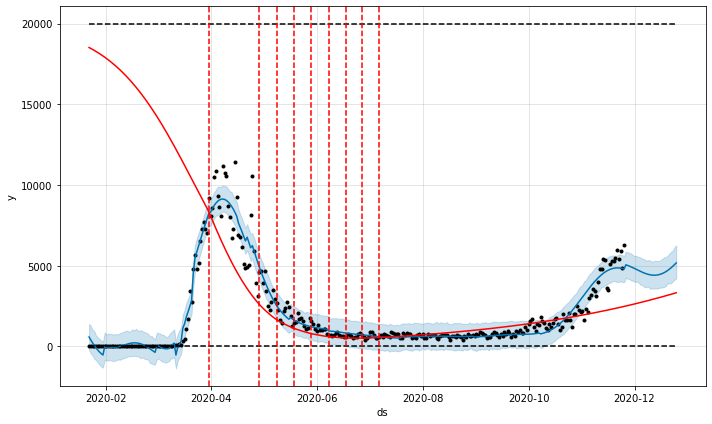

In [14]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/brook/venvs/covid-xprize/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


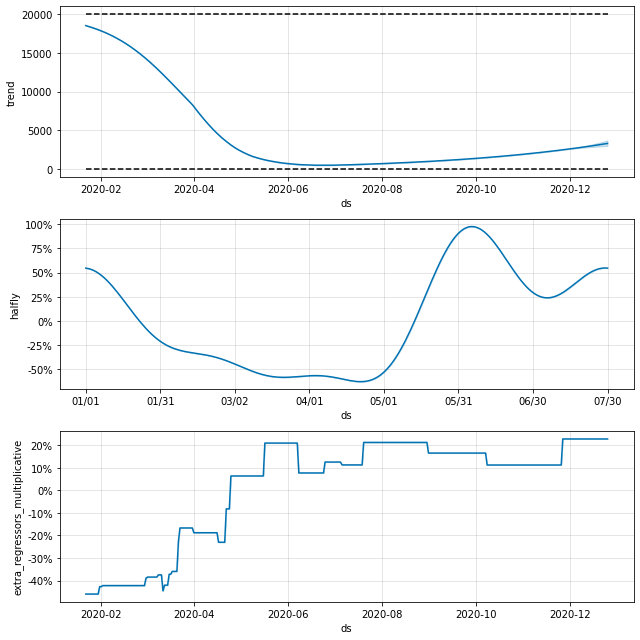

In [15]:
fig2 = model.plot_components(forecast)